In [14]:
!pip install xgboost

In [31]:
import numpy as np
import pandas as pd
import xgboost as xgb
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files

uploaded = files.upload()
df=pd.read_csv(list(uploaded.keys())[0],sep=',') #carga el dataset (en CSV) desde el pc en un dataframe de pandas

# Cargar los datos
#df = pd.read_csv("assets/GeneracionFiltrado.csv")

Saving Generacion_Solar.csv to Generacion_Solar (3).csv


In [32]:
# Preprocesamiento simple (ejemplo)
X = df.drop(columns=['Date','Generacion'])
y = df['Generacion']


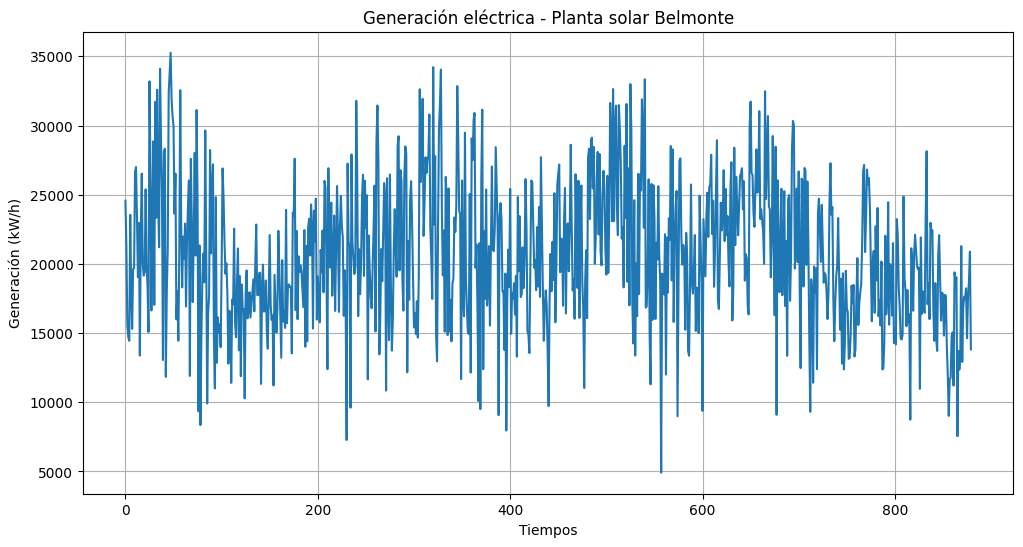

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Generación eléctrica - Planta solar Belmonte")
ax.set_xlabel('Tiempos')
start=0
end=7*52*5
ax.plot(df['Generacion'][start:end])
ax.set_ylabel("Generación (kW/h)")
plt.grid(True)
plt.show()

In [21]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
# Convertir datos a DMatrix y especificar GPU
dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
dtest = xgb.DMatrix(X_test, label=y_test, nthread=-1)

# Entrenar directamente con xgb.train (más controlado)
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'rmse'
}

start_gpu = time.time()
booster = xgb.train(params, dtrain, num_boost_round=100)
print(f"GPU time: {time.time() - start_gpu:.2f} seconds")



GPU time: 0.11 seconds


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:19:13] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:19:13] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [25]:
# Predicción
y_pred = booster.predict(dtest)
print(y_pred[:10])

[25802.836  25982.59   27036.814  28882.406  15968.5205 18045.48
 11665.57   24124.871  22069.336  12145.621 ]


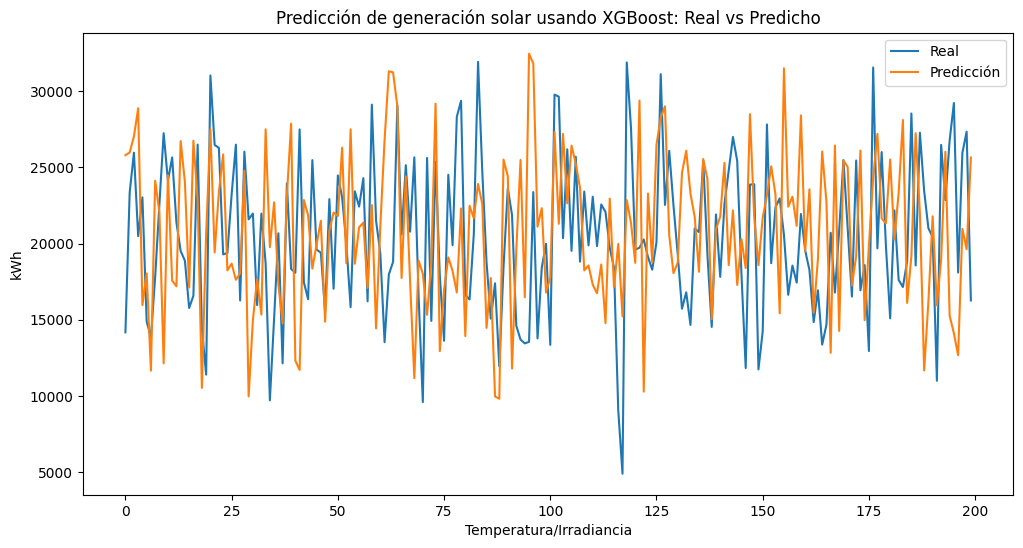

RMSE: 2683.770139979189
R² Score: 0.7617757644838652


In [34]:
# Graficamos
plt.figure(figsize=(12, 6))
plt.plot(np.array(y_train[:200]), label='Real')
plt.plot(y_pred[:200], label='Predicción')
plt.xlabel("Temperatura/Irradiancia")
plt.ylabel("kWh")
plt.legend()
plt.title("Predicción de generación solar usando XGBoost: Real vs Predicho")
plt.show()

# Evaluación

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))

In [35]:
evals_result = {}

booster = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"),(dtest, "test")],  # También puedes incluir (dtest, "test") si quieres ver ambos
    evals_result=evals_result,
    verbose_eval=False
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:24:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:24:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


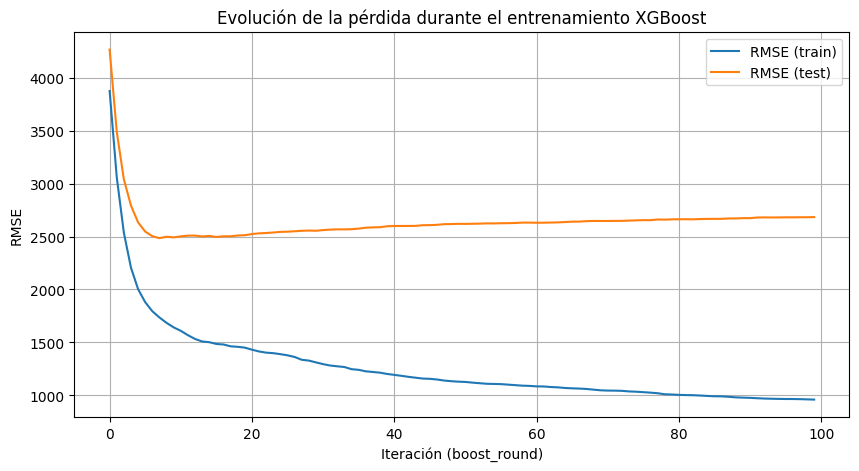

In [36]:
# Extraer valores de RMSE por iteración
train_rmse = evals_result["train"]["rmse"]
test_rmse = evals_result["test"]["rmse"]

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label="RMSE (train)")
plt.plot(test_rmse, label="RMSE (test)")
plt.xlabel("Iteración (boost_round)")
plt.ylabel("RMSE")
plt.title("Evolución de la pérdida durante el entrenamiento XGBoost")
plt.legend()
plt.grid(True)
plt.show()